# Figure S6
This workbook runs PCA comparisons between plasmid and gene data shown in Figure S6. It also creates Figure S10 which compares PCA of different dimensions on the gene data.

In [34]:
import pickle
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import colorcet as cc
import seaborn as sns
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram, fcluster
from scipy.spatial.distance import pdist
from scipy.stats import chi2_contingency
from sklearn.cluster import AgglomerativeClustering
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

In [35]:
plasmid_file = "../0_Data/0_Raw/best_hits_1000bp_v11.csv"
pa_filename = "../0_Data/0_Raw/no_merge_paralogs/gene_presence_absence.Rtab"

In [36]:
# create screeplot from PCA
def perform_pca_and_scree_plot(ax, data, num_components=10, title=''):
    # standardize numerical data
    data_pca = data.select_dtypes(include=['number'])
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(data_pca)
    
    # initialize and fit PCA
    pca = PCA(n_components=num_components)
    pca.fit(data_standardized)
    
    # calculate cumulative explained variance from eigenvalues
    eigenvalues = pca.explained_variance_
    cumulative_variance = eigenvalues / np.sum(eigenvalues)
    
    # output plot
    ax.bar(range(1, num_components + 1), cumulative_variance, align='center')
    ax.set_xticks(range(1, num_components + 1))
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Proportion of Explained Variance')
    ax.set_title(title)
    
    scree_df = pd.DataFrame({'Component': range(1, num_components + 1), 'Variance': cumulative_variance})
    
    return scree_df

In [37]:
# import and clean plasmid data
plasmids = pd.read_csv(plasmid_file)
plasmids = plasmids.rename(columns={"assembly_id": "Isolate"})
plasmids['Isolate'] = plasmids['Isolate'].str.replace(r'GCF_\d+\.\d+_', '', regex=True)
plasmids['Isolate'] = plasmids['Isolate'].str.replace(r'_genomic', '', regex=True) 
plasmids = plasmids[["Isolate", "plasmid_name"]].drop_duplicates().copy()

plasmids = (plasmids.assign(value=1) 
             .pivot(index='Isolate', columns='plasmid_name', values='value') 
             .fillna(0) 
             .reset_index() 
             .rename_axis(None, axis=1)
)
plasmids.iloc[:, 1:] = plasmids.iloc[:, 1:].astype(int)
plasmids = plasmids.set_index("Isolate")

print(plasmids.shape)
plasmids.head()

(82, 40)


,chromosome,cp26,cp32-1,cp32-1+5,cp32-10,cp32-11,cp32-12,cp32-13,cp32-2,cp32-3,cp32-3+10,cp32-4,cp32-5,cp32-6,cp32-7,cp32-8,cp32-9,cp32-9-4,cp9,cp9-3,lp17,lp21,lp21-cp9,lp25,lp28-1,lp28-11,lp28-2,lp28-3,lp28-4,lp28-5,lp28-6,lp28-7,lp28-8,lp28-9,lp32-3,lp36,lp38,lp5,lp54,lp56
Isolate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ASM1913465v1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
ASM215146v1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
ASM215148v1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
ASM215150v1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
ASM2466215v1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0


In [38]:
# import and transpose gene data
genes = pd.read_csv(pa_filename, sep="\t").set_index("Gene").T

genes.shape
genes.head()

Gene     group_1286  group_1204  group_1203  group_1202  group_1201  \
B331P             1           1           1           1           1   
B418P             1           1           1           1           1   
B500P             1           1           1           1           1   
ESI26H            1           1           1           1           1   
ESI361H           1           1           1           1           1   

Gene     group_1200  group_1199  nCS2  guaB  immA  acyP  celA  group_1196  \
B331P             1           1     1     1     1     1     1           1   
B418P             1           1     1     1     1     1     1           1   
B500P             1           1     1     1     1     1     1           1   
ESI26H            1           1     1     1     1     1     1           1   
ESI361H           1           1     1     1     1     1     1           1   

Gene     group_1195  group_1194  group_1193  celC  celB  resT  guaA  \
B331P             1           1           1     1     1     1     1   
B418P             1           1           1     1     1     1     1   
B500P             1           1           1     1     1     1     1   
ESI26H            1           1           1     1     1     1     1   
ESI361H           1           1           1     1     1     1     1   

Gene     group_1192  group_1191  group_1190  group_1189  group_1188  pspE  \
B331P             1           1           1           1           1     1   
B418P             1           1           1           1           1     1   
B500P             1           1           1           1           1     1   
ESI26H            1           1           1           1           1     1   
ESI361H           1           1           1           1           1     1   

Gene     tmk  tadD  group_1186  group_1183  wcaA  group_1179  pepF  pdeB  \
B331P      1     1           1           1     1           1     1     1   
B418P      1     1           1           1     1           1     1     1   
B500P      1     1           1           1     1           1     1     1   
ESI26H     1     1           1           1     1           1     1     1   
ESI361H    1     1           1           1     1           1     1     1   

Gene     folD  yliI  yqxC  potA  group_1163  group_1161  pepP  group_1158  \
B331P       1     1     1     1           1           1     1           1   
B418P       1     1     1     1           1           1     1           1   
B500P       1     1     1     1           1           1     1           1   
ESI26H      1     1     1     1           1           1     1           1   
ESI361H     1     1     1     1           1           1     1           1   

Gene     corB~~~tlyC  hMG1  pASTA  group_1156  group_1155  tolC  group_1153  \
B331P              1     1      1           1           1     1           1   
B418P              1     1      1           1           1     1           1   
B500P              1     1      1           1           1     1           1   
ESI26H             1     1      1           1           1     1           1   
ESI361H            1     1      1           1           1     1           1   

Gene     group_1152  yfmG  yitT  lepA  group_1151  batD  mutL  yibQ  queA  \
B331P             1     1     1     1           1     1     1     1     1   
B418P             1     1     1     1           1     1     1     1     1   
B500P             1     1     1     1           1     1     1     1     1   
ESI26H            1     1     1     1           1     1     1     1     1   
ESI361H           1     1     1     1           1     1     1     1     1   

Gene     group_1147  rlmB  group_1143  group_1142  hisS  group_1141  \
B331P             1     1           1           1     1           1   
B418P             1     1           1           1     1           1   
B500P             1     1           1           1     1           1   
ESI26H            1     1           1           1     1           1   
ESI361H

## Figure S6

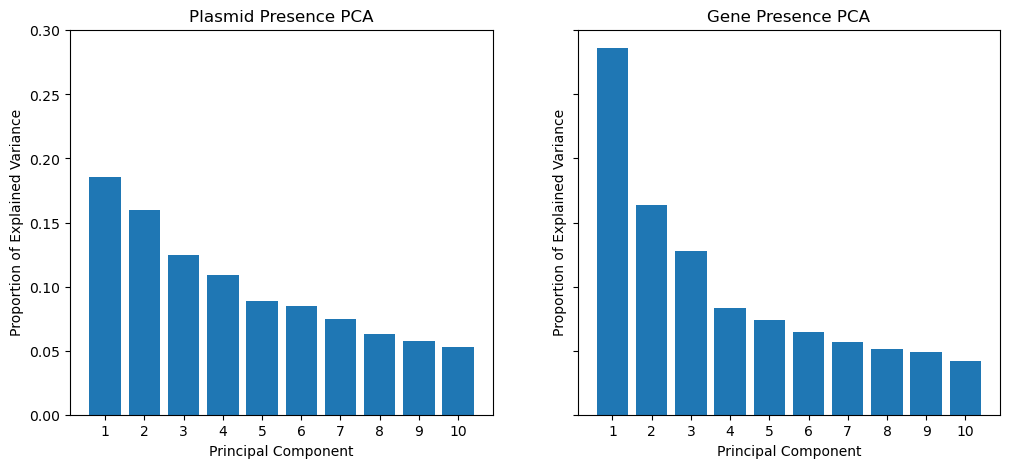

In [39]:
# compare 10-dimensional PCA on the plasmid and gene data
dim=10
fig, ax = plt.subplots(figsize=(12,5),ncols=2, sharey=True)
scree_plasmids = perform_pca_and_scree_plot(ax[0], plasmids, dim, "Plasmid Presence PCA")
scree_genes = perform_pca_and_scree_plot(ax[1], genes, dim, "Gene Presence PCA")


In [40]:
# create a joint dataframe for cumulative variance according to both PCAs
scree_plasmids = scree_plasmids.rename(columns={"Variance":"Plasmids"})
scree_genes = scree_genes.rename(columns={"Variance":"Genes"})
scree = scree_plasmids.merge(scree_genes, on="Component", how="inner")
scree_melted = scree.melt(id_vars='Component', var_name='Category', value_name='Variance')
scree['Cumulative_Plasmids'] = scree['Plasmids'].cumsum()
scree['Cumulative_Genes'] = scree['Genes'].cumsum()

new_row = pd.DataFrame({'Component': [0], 'Plasmids': np.nan, 'Genes': np.nan, 'Cumulative_Plasmids': [0], 'Cumulative_Genes': [0]})

scree = pd.concat([new_row, scree]).reset_index(drop=True)
scree

,Component,Plasmids,Genes,Cumulative_Plasmids,Cumulative_Genes
0,0,NaN,NaN,0.000000,0.000000
1,1,0.185662,0.286197,0.185662,0.286197
2,2,0.159765,0.163852,0.345428,0.450049
3,3,0.124694,0.128171,0.470122,0.578220
4,4,0.108719,0.083576,0.578840,0.661797
5,5,0.088653,0.073733,0.667493,0.735530
6,6,0.084723,0.064590,0.752216,0.800119
7,7,0.074758,0.057120,0.826974,0.857240
8,8,0.063220,0.051580,0.890194,0.908820
9,9,0.057299,0.049334,0.947493,0.958154


(0.0, 1.0)

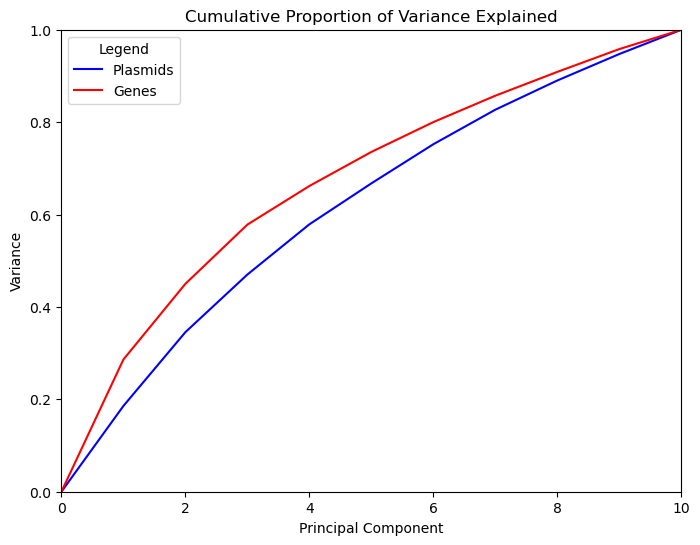

In [41]:
# generate a lineplot comparing cumulative variance between plasmid and gene PCA runs
fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(data=scree, x="Component", y="Cumulative_Plasmids",ax=ax, color="blue", label="Plasmids")
sns.lineplot(data=scree, x="Component", y="Cumulative_Genes",ax=ax,color="red", label="Genes")
ax.legend(title="Legend", loc="upper left")  # Change location
ax.set_title("Cumulative Proportion of Variance Explained")
ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance")
ax.set_xlim([0,dim])
ax.set_ylim([0,1])

# Figure S10

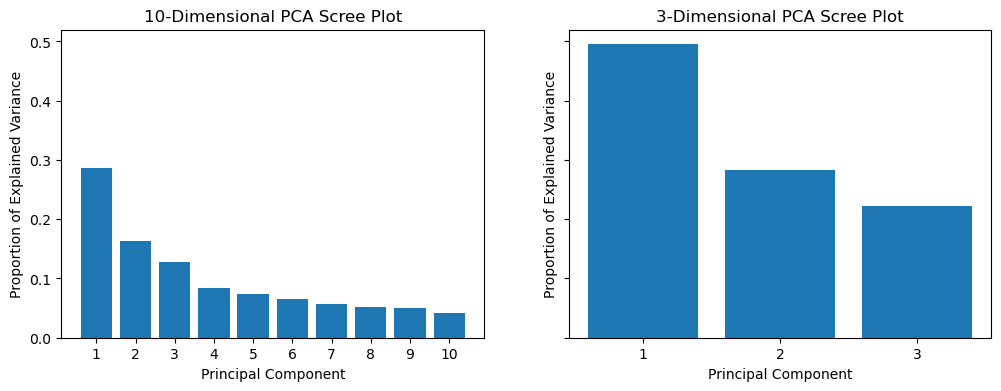

In [42]:
# generate screeplots for 10 and 3 dimensional PCA runs on the gene data
fig, ax = plt.subplots(figsize=(12,4),ncols=2, sharey=True)
scree_10 = perform_pca_and_scree_plot(ax[0], genes, 10, "10-Dimensional PCA Scree Plot")
scree_3 = perform_pca_and_scree_plot(ax[1], genes, 3, "3-Dimensional PCA Scree Plot")
